In [1]:
import os, io, json, ast, sys, subprocess, shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
# --------------------------
# Settings
# --------------------------
USE_EMBEDDINGS = True            # set False to skip the embeddings variant
EMB_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
SAVE_DIR = Path("models_out"); SAVE_DIR.mkdir(parents=True, exist_ok=True)
SEP_TOKEN = "[SEP]"
MAX_FEATURES = 10_000
RANDOM_STATE = 42
CLASS_NAMES = ["unsat", "sat"]   # 0 -> unsat, 1 -> sat

fname = "fragment_S.csv"


In [3]:
# --------------------------
# Helpers
# --------------------------
def normalize_label(v):
    if isinstance(v, str):
        s = v.strip().lower()
        if s in {"sat","satisfiable","1","true"}:  return 1
        if s in {"unsat","unsatisfiable","0","false"}:  return 0
    if isinstance(v, (int, np.integer)):
        if v in (0,1): return int(v)
    raise ValueError(f"Unrecognized label: {v!r}")

def parse_sent(cell, sep=SEP_TOKEN):
    if isinstance(cell, list): return f" {sep} ".join(cell)
    if isinstance(cell, str):
        s = cell.strip()
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list) and all(isinstance(x, str) for x in parsed):
                    return f" {sep} ".join(parsed)
            except Exception:
                pass
        return s
    return str(cell)

def metrics(y_true, y_pred, avg="macro"):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=avg, zero_division=0)
    return {"accuracy": acc, f"precision_{avg}": p, f"recall_{avg}": r, f"f1_{avg}": f1}

def plot_cm(cm, class_names, title, normalize=False, save_path=None):
    cm_plot = cm.astype(float)
    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0.0] = 1.0
        cm_plot = cm_plot / row_sums

    plt.figure(figsize=(4.5, 4))
    im = plt.imshow(cm_plot, interpolation='nearest', cmap='Blues', aspect='equal')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # annotate cells
    thresh = cm_plot.max() / 2.0 if cm_plot.max() > 0 else 0.5
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = f"{cm_plot[i, j]:.2f}" if normalize else f"{int(cm_plot[i, j])}"
            plt.text(j, i, val,
                     ha="center", va="center",
                     color="white" if cm_plot[i, j] > thresh else "black", fontsize=11)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()


In [4]:
# --------------------------
# Load data
# --------------------------
df = pd.read_csv(fname)
label_col = "label" if "label" in df.columns else "sat" if "sat" in df.columns else None
if label_col is None: raise ValueError("No label column found. Expected 'label' or 'sat'.")
if "sentences" not in df.columns: raise ValueError("Expected a 'sentences' column.")

df["y"] = df[label_col].apply(normalize_label).astype(int)
df["text"] = df["sentences"].apply(parse_sent)

X = df["text"].tolist()
y = df["y"].to_numpy()

Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)


In [5]:
# --------------------------
# TF-IDF model spaces
# --------------------------
spaces = {}
vec_tfidf = [("tfidf", TfidfVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES))]

spaces["logreg_tfidf"] = (
    Pipeline(vec_tfidf + [("clf", LogisticRegression(solver="liblinear", max_iter=1000, random_state=RANDOM_STATE))]),
    {"clf__C": [0.01, 0.1, 1.0, 10.0]},
    -1
)
spaces["svm_linear_tfidf"] = (
    Pipeline(vec_tfidf + [("clf", LinearSVC())]),
    {"clf__C": [0.1, 1.0]},
    -1
)
spaces["decision_tree_tfidf"] = (
    Pipeline(vec_tfidf + [("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    {"clf__criterion": ["gini", "entropy"], "clf__max_depth": [10, 20, None]},
    -1
)
spaces["random_forest_tfidf"] = (
    Pipeline(vec_tfidf + [("clf", RandomForestClassifier(random_state=RANDOM_STATE))]),
    {"clf__criterion": ["gini", "entropy"], "clf__n_estimators": [100, 200], "clf__max_features": ["sqrt"]},
    -1
)

summary = {"file": fname, "results": {}}



=== logreg_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 10.0}

Validation report:
              precision    recall  f1-score   support

           0     0.6515    0.7167    0.6825      1020
           1     0.6708    0.6010    0.6340       980

    accuracy                         0.6600      2000
   macro avg     0.6612    0.6588    0.6583      2000
weighted avg     0.6610    0.6600    0.6588      2000



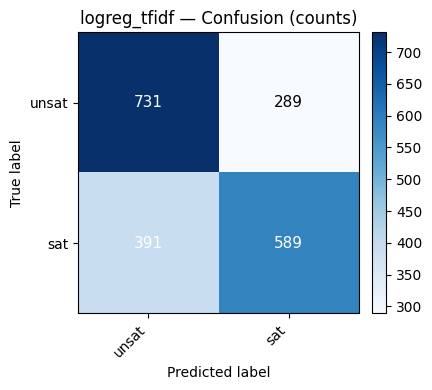

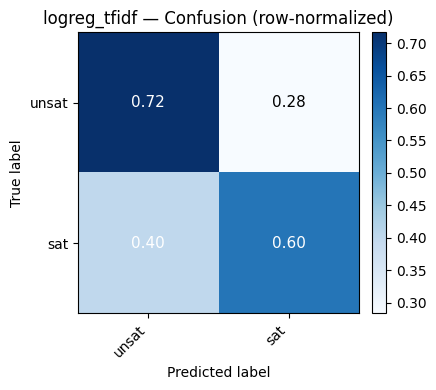


=== svm_linear_tfidf ===
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params: {'clf__C': 1.0}

Validation report:
              precision    recall  f1-score   support

           0     0.6493    0.7225    0.6840      1020
           1     0.6728    0.5939    0.6309       980

    accuracy                         0.6595      2000
   macro avg     0.6611    0.6582    0.6574      2000
weighted avg     0.6609    0.6595    0.6580      2000



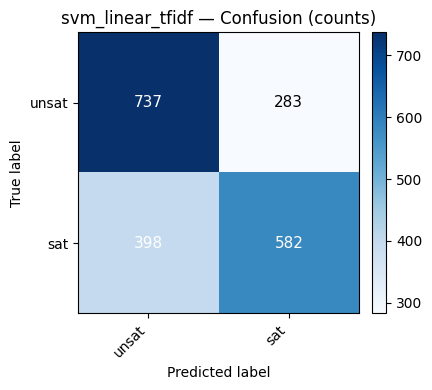

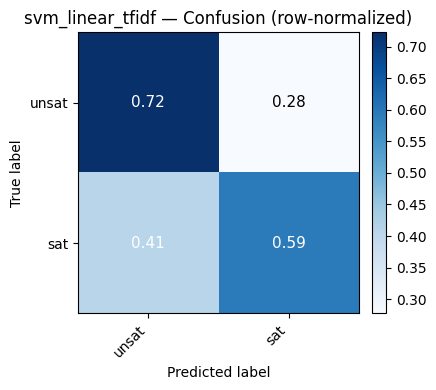


=== decision_tree_tfidf ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 10}

Validation report:
              precision    recall  f1-score   support

           0     0.5920    0.6657    0.6267      1020
           1     0.6002    0.5224    0.5586       980

    accuracy                         0.5955      2000
   macro avg     0.5961    0.5941    0.5927      2000
weighted avg     0.5960    0.5955    0.5933      2000



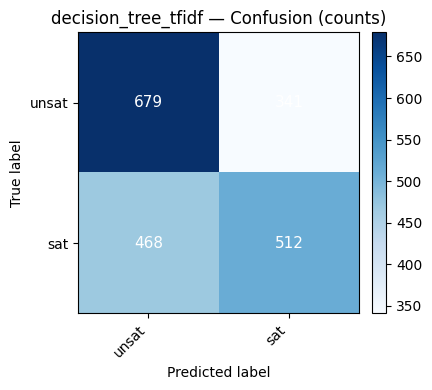

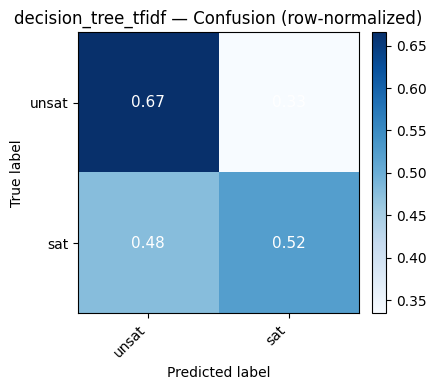


=== random_forest_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}

Validation report:
              precision    recall  f1-score   support

           0     0.6818    0.6784    0.6801      1020
           1     0.6670    0.6704    0.6687       980

    accuracy                         0.6745      2000
   macro avg     0.6744    0.6744    0.6744      2000
weighted avg     0.6745    0.6745    0.6745      2000



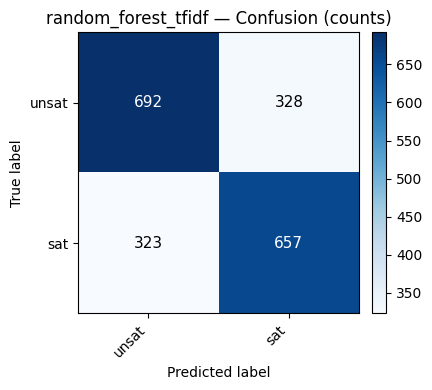

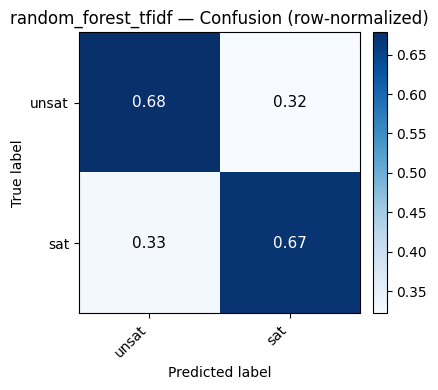

In [6]:
# --------------------------
# Train TF-IDF models
# --------------------------
from sklearn.model_selection import GridSearchCV

for name, (pipe, grid, n_jobs) in spaces.items():
    print(f"\n=== {name} ===")
    gs = GridSearchCV(pipe, grid, scoring="f1", cv=3, n_jobs=n_jobs, verbose=1, error_score="raise")
    gs.fit(Xtr, ytr)
    best = gs.best_estimator_
    print("Best params:", gs.best_params_)

    yhat = best.predict(Xval)
    print("\nValidation report:")
    print(classification_report(yval, yhat, digits=4))

    cm = confusion_matrix(yval, yhat, labels=[0,1])

    # Visual + save (counts)
    cm_counts_path = SAVE_DIR / f"cm_{name}_counts.png"
    plot_cm(cm, CLASS_NAMES, f"{name} — Confusion (counts)", normalize=False, save_path=cm_counts_path)

    # Visual + save (normalized)
    cm_norm_path = SAVE_DIR / f"cm_{name}_normalized.png"
    plot_cm(cm, CLASS_NAMES, f"{name} — Confusion (row-normalized)", normalize=True, save_path=cm_norm_path)

    model_path = SAVE_DIR / f"{name}.joblib"
    joblib.dump(best, model_path)

    summary["results"][name] = {
        "best_params": gs.best_params_,
        "metrics_macro": metrics(yval, yhat, "macro"),
        "metrics_binary": metrics(yval, yhat, "binary"),
        "confusion_matrix": cm.tolist(),
        "cm_counts_path": str(cm_counts_path),
        "cm_normalized_path": str(cm_norm_path),
        "model_path": str(model_path)
    }


=== logreg_emb (precomputed) ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'C': 0.01}

Validation report:
              precision    recall  f1-score   support

           0     0.6800    0.6833    0.6817      1020
           1     0.6687    0.6653    0.6670       980

    accuracy                         0.6745      2000
   macro avg     0.6744    0.6743    0.6743      2000
weighted avg     0.6745    0.6745    0.6745      2000



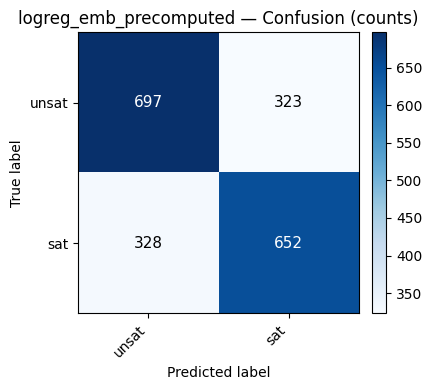

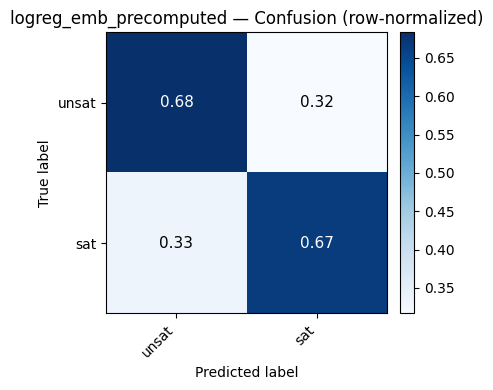

In [7]:
# --------------------------
# Embeddings variant (SAFE): precompute embeddings, then grid over the classifier
# --------------------------
if USE_EMBEDDINGS:
    try:
        from sentence_transformers import SentenceTransformer
    except Exception:
        print("Installing sentence-transformers ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "sentence-transformers"])
        from sentence_transformers import SentenceTransformer

    print("\n=== logreg_emb (precomputed) ===")
    st_model = SentenceTransformer(EMB_MODEL_NAME)  # uses CPU/GPU automatically

    def embed(texts, batch_size=256):
        return st_model.encode(
            list(texts),
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=False
        )

    # Precompute once
    Xtr_emb = embed(Xtr)
    Xval_emb = embed(Xval)

    # Optional scaling
    scaler = StandardScaler(with_mean=True)
    Xtr_emb_s = scaler.fit_transform(Xtr_emb)
    Xval_emb_s = scaler.transform(Xval_emb)

    # Grid search on classifier only
    logreg = LogisticRegression(solver="liblinear", max_iter=1000, random_state=RANDOM_STATE)
    param_grid = {"C": [0.01, 0.1, 1.0, 10.0]}
    gs_emb = GridSearchCV(logreg, param_grid, scoring="f1", cv=3, n_jobs=-1, verbose=1, error_score="raise")
    gs_emb.fit(Xtr_emb_s, ytr)
    print("Best params:", gs_emb.best_params_)

    yhat = gs_emb.predict(Xval_emb_s)
    print("\nValidation report:")
    print(classification_report(yval, yhat, digits=4))

    cm = confusion_matrix(yval, yhat, labels=[0,1])

    # Visual + save for embeddings
    cm_counts_path = SAVE_DIR / f"cm_logreg_emb_precomputed_counts.png"
    plot_cm(cm, CLASS_NAMES, "logreg_emb_precomputed — Confusion (counts)", normalize=False, save_path=cm_counts_path)

    cm_norm_path = SAVE_DIR / f"cm_logreg_emb_precomputed_normalized.png"
    plot_cm(cm, CLASS_NAMES, "logreg_emb_precomputed — Confusion (row-normalized)", normalize=True, save_path=cm_norm_path)

    # Save classifier + scaler as a bundle
    bundle = {"scaler": scaler, "clf": gs_emb.best_estimator_, "embedding_model": EMB_MODEL_NAME}
    model_path = SAVE_DIR / "logreg_emb_precomputed.joblib"
    joblib.dump(bundle, model_path)

    summary["results"]["logreg_emb_precomputed"] = {
        "best_params": gs_emb.best_params_,
        "metrics_macro": metrics(yval, yhat, "macro"),
        "metrics_binary": metrics(yval, yhat, "binary"),
        "confusion_matrix": cm.tolist(),
        "cm_counts_path": str(cm_counts_path),
        "cm_normalized_path": str(cm_norm_path),
        "model_path": str(model_path)
    }

In [8]:
# --------------------------
# Save summary + zip for download
# --------------------------
rep_path = SAVE_DIR / "report.json"
with open(rep_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print(f"\nSaved models, CMs & report to: {SAVE_DIR.resolve()}")
print(json.dumps(summary, indent=2)[:1200], "...")

zip_path = shutil.make_archive("models_out", "zip", root_dir=SAVE_DIR)
print(f"\nZipped: {zip_path}")
try:
    files.download(zip_path)
except Exception:
    print("If the download prompt doesn't appear, use the Files pane to download 'models_out.zip'.")


Saved models, CMs & report to: /content/models_out
{
  "file": "fragment_S.csv",
  "results": {
    "logreg_tfidf": {
      "best_params": {
        "clf__C": 10.0
      },
      "metrics_macro": {
        "accuracy": 0.66,
        "precision_macro": 0.6611789880582591,
        "recall_macro": 0.6588435374149659,
        "f1_macro": 0.6582773762536949
      },
      "metrics_binary": {
        "accuracy": 0.66,
        "precision_binary": 0.6708428246013668,
        "recall_binary": 0.6010204081632653,
        "f1_binary": 0.6340150699677072
      },
      "confusion_matrix": [
        [
          731,
          289
        ],
        [
          391,
          589
        ]
      ],
      "cm_counts_path": "models_out/cm_logreg_tfidf_counts.png",
      "cm_normalized_path": "models_out/cm_logreg_tfidf_normalized.png",
      "model_path": "models_out/logreg_tfidf.joblib"
    },
    "svm_linear_tfidf": {
      "best_params": {
        "clf__C": 1.0
      },
      "metrics_macro": {
   